# **Group Exercise 2 - Regression Analysis and Feature Selection**

**Group Members:**

*   Simran Amesar
*   Shreya Chowdary Challagulla
*   Ishwari Thakur
*   Pooja Chandrappa
*   Yuvraj Ghag



Import necessary libraries for data manipulation, preprocessing, model training, and evaluation.

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV



### **Load Train & Test Data**

Load the training and test datasets for the house price prediction task.

In [149]:


train_path = "/content/train.csv"
test_path  = "/content/test.csv"
TARGET_COL = "SalePrice"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)


Train dataset shape: (1460, 81)
Test dataset shape: (1459, 80)


The test data do not contain the output variable.

In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1.Preprocessing**

In [151]:
print("\nMissing values per column (TRAIN):")
train_missing = train_df.isna().sum().sort_values(ascending=False)
print(train_missing[train_missing > 0])

print("\nMissing values per column (TEST):")
test_missing = test_df.isna().sum().sort_values(ascending=False)
print(test_missing[test_missing > 0])



Missing values per column (TRAIN):
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

Missing values per column (TEST):
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageFinish      78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st  

These columns are dropped

In [152]:
cols_to_drop = ["PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType", "FireplaceQu"]

In [153]:
train_df = train_df.drop(columns=cols_to_drop, errors="ignore")
test_df  = test_df.drop(columns=cols_to_drop, errors="ignore")

# **1.Handle missing values ​​and outliers.**

Check for missing values across all  feature(Categorical and numerical) to determine which columns require imputation during preprocessing.
Imputed the numerical values with the median and categorical values with mode.

In [154]:
y_train = train_df[TARGET_COL]
X_train = train_df.drop(columns=[TARGET_COL])
X_test  = test_df.copy()

print("Missing values in X_train BEFORE imputation:", int(X_train.isna().sum().sum()))
print("Missing values in X_test BEFORE imputation:", int(X_test.isna().sum().sum()))


num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(exclude=["int64", "float64"]).columns

print("\nNumeric columns:")
print(list(num_cols))

print("\nCategorical columns:")
print(list(cat_cols))

num_medians = X_train[num_cols].median()

cat_modes = X_train[cat_cols].mode().iloc[0]

X_train[num_cols] = X_train[num_cols].fillna(num_medians)
X_test[num_cols]  = X_test[num_cols].fillna(num_medians)

X_train[cat_cols] = X_train[cat_cols].fillna(cat_modes)
X_test[cat_cols]  = X_test[cat_cols].fillna(cat_modes)


print("Missing values in X_train AFTER imputation:", int(X_train.isna().sum().sum()))
print("Missing values in X_test AFTER imputation:", int(X_test.isna().sum().sum()))

Missing values in X_train BEFORE imputation: 860
Missing values in X_test BEFORE imputation: 869

Numeric columns:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Categorical columns:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Centr

Outliers were identified using the IQR(InterQuartile Range) method on numeric features and capped to there respective lower and upper bounds to improve the stability of the dataset.


In [155]:
import pandas as pd

SPARSE_COLS = [
    "EnclosedPorch", "BsmtFinSF2", "ScreenPorch", "BsmtHalfBath",
    "LowQualFinSF", "3SsnPorch", "MiscVal", "PoolArea"
]
exclude_outlier_cols = ["Id"] + SPARSE_COLS

numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns


outlier_summary_before = []
for col in numeric_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier_count = ((X_train[col] < lower) | (X_train[col] > upper)).sum()

    outlier_summary_before.append({
        "Column": col,
        "Outlier_Count_Before": int(outlier_count),
        "Lower_Bound": float(lower),
        "Upper_Bound": float(upper)
    })

outliers_before_df = pd.DataFrame(outlier_summary_before).sort_values(
    "Outlier_Count_Before", ascending=False
)

print("\n Outliers BEFORE handling (top 20 columns):")
print(outliers_before_df.head(20))


X_train_capped = X_train.copy()
X_test_capped  = X_test.copy()

handled_cols = []

for _, r in outliers_before_df.iterrows():
    col = r["Column"]
    if col in exclude_outlier_cols:
        continue

    lower = r["Lower_Bound"]
    upper = r["Upper_Bound"]

    X_train_capped[col] = X_train_capped[col].clip(lower=lower, upper=upper)
    X_test_capped[col]  = X_test_capped[col].clip(lower=lower, upper=upper)

    handled_cols.append(col)

print(f"\n Outlier handling applied to {len(handled_cols)} numeric columns .")


outlier_summary_after = []
for col in numeric_cols:
    Q1 = X_train_capped[col].quantile(0.25)
    Q3 = X_train_capped[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier_count = ((X_train_capped[col] < lower) | (X_train_capped[col] > upper)).sum()

    outlier_summary_after.append({
        "Column": col,
        "Outlier_Count_After": int(outlier_count)
    })

outliers_after_df = pd.DataFrame(outlier_summary_after).sort_values(
    "Outlier_Count_After", ascending=False
)

print("\n Outliers AFTER handling :")
print(outliers_after_df.head(20))


outliers_after_handled_df = outliers_after_df[outliers_after_df["Column"].isin(handled_cols)] \
    .sort_values("Outlier_Count_After", ascending=False)

print("\n Outliers AFTER handling :")
print(outliers_after_handled_df.head(20))


outlier_indices_before = set()
for _, r in outliers_before_df.iterrows():
    col = r["Column"]
    if col in exclude_outlier_cols:
        continue
    lower, upper = r["Lower_Bound"], r["Upper_Bound"]
    idx = X_train[(X_train[col] < lower) | (X_train[col] > upper)].index
    outlier_indices_before.update(idx)

outlier_indices_after = set()
for col in handled_cols:

    Q1 = X_train_capped[col].quantile(0.25)
    Q3 = X_train_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    idx = X_train_capped[(X_train_capped[col] < lower) | (X_train_capped[col] > upper)].index
    outlier_indices_after.update(idx)

print("\n Total OUTLIER ROWS before handling :", len(outlier_indices_before))
print("Total OUTLIER ROWS after handling  :", len(outlier_indices_after))
print("Rows fixed:", len(outlier_indices_before - outlier_indices_after))



 Outliers BEFORE handling (top 20 columns):
           Column  Outlier_Count_Before  Lower_Bound  Upper_Bound
30  EnclosedPorch                   208        0.000        0.000
10     BsmtFinSF2                   167        0.000        0.000
5     OverallCond                   125        3.500        7.500
32    ScreenPorch                   116        0.000        0.000
2     LotFrontage                   106       31.500      107.500
1      MSSubClass                   103      -55.000      145.000
8      MasVnrArea                    98     -246.375      410.625
18   BsmtHalfBath                    82        0.000        0.000
29    OpenPorchSF                    77     -102.000      170.000
3         LotArea                    69     1481.500    17673.500
22   KitchenAbvGr                    68        1.000        1.000
12    TotalBsmtSF                    61       42.000     2052.000
34        MiscVal                    52        0.000        0.000
21   BedroomAbvGr              

# **2.Scale features using standardization or normalization.**

Applying the Standard scaler method and normalizing the numerical features.

In [156]:
num_cols = X_train_capped.select_dtypes(include=["int64", "float64"]).columns

numeric_but_categorical = ["MSSubClass", "MoSold", "YrSold"]

ordinal_cols = ["OverallQual", "OverallCond"]

scale_cols = [
    c for c in num_cols
    if c not in numeric_but_categorical + ordinal_cols + ["Id"]
]

print("Columns being scaled:")
print(scale_cols)

scaler = StandardScaler()

X_train_scaled = X_train_capped.copy()
X_test_scaled  = X_test_capped.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train_scaled[scale_cols])
X_test_scaled[scale_cols]  = scaler.transform(X_test_scaled[scale_cols])

print("\n Standard scaling complete")
print("Train mean (approx):", X_train_scaled[scale_cols].mean().mean())
print("Train std  (approx):", X_train_scaled[scale_cols].std().mean())

X_train_scaled[scale_cols].head()


Columns being scaled:
['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

 Standard scaling complete
Train mean (approx): 1.3804934021178646e-16
Train std  (approx): 0.9680735243013752


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,-0.237456,-0.333244,1.053246,0.878668,0.795643,0.614224,-0.288653,-0.958790,-0.488321,-0.830489,1.164283,-0.120242,0.428636,1.111765,-0.241061,0.789741,1.227585,0.195307,0.0,0.981148,-0.957043,1.017824,0.315946,0.373509,-0.787243,0.350520,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688
1,0.633321,-0.013189,0.156179,-0.429577,-0.667353,1.242296,-0.288653,-0.648290,0.532289,0.289638,-0.796041,-0.120242,-0.502349,-0.821739,3.948809,0.789741,-0.761621,0.195307,0.0,-0.316385,0.608540,-0.108062,0.315946,-0.051541,1.768105,-0.811747,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688
2,-0.063300,0.446022,0.986797,0.830215,0.541858,0.106224,-0.288653,-0.300716,-0.327437,-0.653917,1.191828,-0.120242,0.586571,1.111765,-0.241061,0.789741,1.227585,0.195307,0.0,-0.316385,0.608540,0.934425,0.315946,0.663315,-0.787243,-0.011497,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688
3,-0.527714,-0.027104,-1.870528,-0.720298,-0.667353,-0.517230,-0.288653,-0.055097,-0.739702,-0.540801,0.939328,-0.120242,0.443182,1.111765,-0.241061,-1.026041,-0.761621,0.195307,0.0,0.332382,0.608540,0.809327,1.662750,0.827539,-0.787243,-0.144872,4.092524,-0.116339,-0.270208,-0.068692,-0.087688
4,0.865528,1.283733,0.953572,0.733308,1.945140,0.496460,-0.288653,-0.170955,0.238172,-0.033157,1.621080,-0.120242,1.442744,1.111765,-0.241061,0.789741,1.227585,1.512385,0.0,1.629914,0.608540,0.892726,1.662750,1.764579,0.859156,0.788753,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688


Performing One-hot encoding on categorical features.

In [157]:
cat_cols = X_train_scaled.select_dtypes(include=["object"]).columns

print("\nCategorical columns to encode:")
print(list(cat_cols))

X_train_encoded = pd.get_dummies(
    X_train_scaled,
    columns=cat_cols,
    drop_first=True
)

X_test_encoded = pd.get_dummies(
    X_test_scaled,
    columns=cat_cols,
    drop_first=True
)

X_train_final, X_test_final = X_train_encoded.align(
    X_test_encoded,
    join="left",
    axis=1,
    fill_value=0
)

print("\n One-hot encoding complete")
print("Final train shape:", X_train_final.shape)
print("Final test shape :", X_test_final.shape)

binary_cols = [c for c in X_train_final.columns if X_train_final[c].nunique() <= 2]
X_train_final[binary_cols].head()



Categorical columns to encode:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

 One-hot encoding complete
Final train shape: (1460, 230)
Final test shape : (1459, 230)


,KitchenAbvGr,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,True,False,False,

# **3. Perform feature selection.**
Applied LASSO feature selection is applied after scaling and encoding to identify the most important predictors(38 features)  by shrinking less useful features co-efficient to zero.

In [158]:
bool_cols = X_train_final.select_dtypes(include="bool").columns
X_train_fs = X_train_final.copy()
X_test_fs  = X_test_final.copy()

X_train_fs[bool_cols] = X_train_fs[bool_cols].astype(int)
X_test_fs[bool_cols]  = X_test_fs[bool_cols].astype(int)

y_train_log = np.log1p(y_train)

lasso_cv = LassoCV(cv=5, random_state=42, max_iter=5000, n_jobs=-1)
lasso_cv.fit(X_train_fs, y_train_log)

print("Best alpha chosen by CV:", lasso_cv.alpha_)

coef = pd.Series(lasso_cv.coef_, index=X_train_fs.columns)
selected_features = coef[coef != 0].index

print("Total features before selection:", X_train_fs.shape[1])
print("Selected features after LASSO:", len(selected_features))

X_train_selected = X_train_fs[selected_features]
X_test_selected  = X_test_fs[selected_features]

top_features = coef[coef != 0].sort_values(key=np.abs, ascending=False).head(20)
print("\nTop selected features:")
print(top_features)

X_train_selected.head()


Best alpha chosen by CV: 0.0030196495222465005
Total features before selection: 230
Selected features after LASSO: 38

Top selected features:
GrLivArea               0.121913
OverallQual             0.077151
YearBuilt               0.068500
OverallCond             0.054949
TotalBsmtSF             0.044404
GarageCars              0.035703
Condition1_Norm         0.035363
BsmtFinSF1              0.032712
LotArea                 0.029786
MSZoning_RM            -0.029680
Foundation_PConc        0.029186
Neighborhood_Crawfor    0.022489
Fireplaces              0.022423
YearRemodAdd            0.020814
CentralAir_Y            0.017199
SaleType_New            0.016664
HeatingQC_TA           -0.015326
Functional_Typ          0.014190
ScreenPorch             0.011330
GarageArea              0.010212
dtype: float64


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSZoning_RM,Neighborhood_Crawfor,Condition1_Norm,Foundation_PConc,BsmtExposure_No,HeatingQC_TA,CentralAir_Y,KitchenQual_TA,Functional_Typ,GarageFinish_Unf,SaleType_New,SaleCondition_Normal
0,1,60,-0.237456,-0.333244,7,5.0,1.053246,0.878668,0.614224,-0.288653,-0.488321,0.428636,1.111765,0.789741,1.227585,-0.957043,0.315946,0.373509,-0.787243,0.350520,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2008,0,0,1,1,1,0,1,0,1,0,0,1
1,2,20,0.633321,-0.013189,6,7.5,0.156179,-0.429577,1.242296,-0.288653,0.532289,-0.502349,-0.821739,0.789741,-0.761621,0.608540,0.315946,-0.051541,1.768105,-0.811747,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2007,0,0,0,0,0,0,1,1,1,0,0,1
2,3,60,-0.063300,0.446022,7,5.0,0.986797,0.830215,0.106224,-0.288653,-0.327437,0.586571,1.111765,0.789741,1.227585,0.608540,0.315946,0.663315,-0.787243,-0.011497,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2008,0,0,1,1,0,0,1,0,1,0,0,1
3,4,70,-0.527714,-0.027104,7,5.0,-1.870528,-0.720298,-0.517230,-0.288653,-0.739702,0.443182,1.111765,-1.026041,-0.761621,0.608540,1.662750,0.827539,-0.787243,-0.144872,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,2006,0,1,1,0,1,0,1,0,1,1,0,0
4,5,60,0.865528,1.283733,8,5.0,0.953572,0.733308,0.496460,-0.288653,0.238172,1.442744,1.111765,0.789741,1.227585,0.608540,1.662750,1.764579,0.859156,0.788753,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2008,0,0,1,1,0,0,1,0,1,0,0,1


# **2. Build and Evaluate Models**

# **1. Train a Linear Regression model.**

Performed Linear regression with the processed data and calculated root mean squared error and R2 score.
The model achived strong performance with an R2 of 0.91 on trained data and cross validated RMSE of 0.13 indicating good predicting accuracy and minimal overfitting

In [159]:
X = X_train_selected
y = y_train_log

lr = LinearRegression()
lr.fit(X, y)

y_train_pred = lr.predict(X)

r2 = r2_score(y, y_train_pred)
rmse = np.sqrt(mean_squared_error(y, y_train_pred))

print("Linear Regression Performance (Train)")
print("R² Score:", r2)
print("RMSE (log scale):", rmse)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse = -cross_val_score(
    lr,
    X,
    y,
    cv=kf,
    scoring="neg_root_mean_squared_error"
)

cv_r2 = cross_val_score(
    lr,
    X,
    y,
    cv=kf,
    scoring="r2"
)

print("\n5-Fold Cross-Validation Results")
print("CV RMSE (log scale):", cv_rmse.mean())
print("CV R² Score:", cv_r2.mean())


Linear Regression Performance (Train)
R² Score: 0.9070876083341871
RMSE (log scale): 0.12171656099076666

5-Fold Cross-Validation Results
CV RMSE (log scale): 0.12806618250311982
CV R² Score: 0.8934199176263938


By using correleation method able to select 33 features

In [160]:
import pandas as pd

corr_with_y = X.apply(lambda col: col.corr(y)).abs().sort_values(ascending=False)

print("Top 20 features by correlation with y:")
print(corr_with_y.head(20))

corr_threshold = 0.05

selected_corr_features = corr_with_y[corr_with_y > corr_threshold].index

print("\nCorrelation threshold:", corr_threshold)
print("Number of selected features:", len(selected_corr_features))

X_corr_selected = X[selected_corr_features]

X_corr_selected.head()


Top 20 features by correlation with y:
OverallQual         0.816842
GrLivArea           0.722437
GarageCars          0.684152
GarageArea          0.661249
TotalBsmtSF         0.644791
FullBath            0.594771
YearBuilt           0.587966
GarageFinish_Unf    0.574553
YearRemodAdd        0.565608
KitchenQual_TA      0.538237
Foundation_PConc    0.530840
Fireplaces          0.491414
LotArea             0.437851
BsmtFinSF1          0.387351
OpenPorchSF         0.383019
LotFrontage         0.375057
CentralAir_Y        0.351599
MSZoning_RM         0.347446
WoodDeckSF          0.341308
HeatingQC_TA        0.335429
dtype: float64

Correlation threshold: 0.05
Number of selected features: 33


,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,GarageFinish_Unf,YearRemodAdd,KitchenQual_TA,Foundation_PConc,Fireplaces,LotArea,BsmtFinSF1,OpenPorchSF,LotFrontage,CentralAir_Y,MSZoning_RM,WoodDeckSF,HeatingQC_TA,SaleType_New,HalfBath,BsmtExposure_No,BsmtFullBath,EnclosedPorch,Functional_Typ,ScreenPorch,Condition1_Norm,SaleCondition_Normal,Neighborhood_Crawfor,PoolArea,OverallCond,3SsnPorch
0,7,0.428636,0.315946,0.373509,-0.488321,0.789741,1.053246,0,0.878668,0,1,-0.957043,-0.333244,0.614224,0.350520,-0.237456,1,0,-0.787243,0,0,1.227585,1,1.111765,-0.359325,1,-0.270208,1,1,0,-0.068692,5.0,-0.116339
1,6,-0.502349,0.315946,-0.051541,0.532289,0.789741,0.156179,0,-0.429577,1,0,0.608540,-0.013189,1.242296,-0.811747,0.633321,1,0,1.768105,0,0,-0.761621,0,-0.821739,-0.359325,1,-0.270208,0,1,0,-0.068692,7.5,-0.116339
2,7,0.586571,0.315946,0.663315,-0.327437,0.789741,0.986797,0,0.830215,0,1,0.608540,0.446022,0.106224,-0.011497,-0.063300,1,0,-0.787243,0,0,1.227585,0,1.111765,-0.359325,1,-0.270208,1,1,0,-0.068692,5.0,-0.116339
3,7,0.443182,1.662750,0.827539,-0.739702,-1.026041,-1.870528,1,-0.720298,0,0,0.608540,-0.027104,-0.517230,-0.144872,-0.527714,1,0,-0.787243,0,0,-0.761621,1,1.111765,4.092524,1,-0.270208,1,0,1,-0.068692,5.0,-0.116339
4,8,1.442744,1.662750,1.764579,0.238172,0.789741,0.953572,0,0.733308,0,1,0.608540,1.283733,0.496460,0.788753,0.865528,1,0,0.859156,0,0,1.227585,0,1.111765,-0.359325,1,-0.270208,1,1,0,-0.068692,5.0,-0.116339


# **2**.Evaluate using R² Score and RMSE.
Comparing the results of both the regression models both correleation and LASSO feature selection models achived similar performance with nearly identical R2 (0.89 approximately) in cross validation and RMSE(~0.13) indicating both feature selection approaches generalize equally well.

In [161]:
X_corr_selected = X[selected_corr_features]

lr = LinearRegression()
lr.fit(X_corr_selected, y)

y_train_pred = lr.predict(X_corr_selected)

r2 = r2_score(y, y_train_pred)
rmse = np.sqrt(mean_squared_error(y, y_train_pred))

print("\nLinear Regression Performance (Train) - Correlation Selected")
print("R² Score:", r2)
print("RMSE (log scale):", rmse)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse = -cross_val_score(
    lr,
    X_corr_selected,
    y,
    cv=kf,
    scoring="neg_root_mean_squared_error"
)

cv_r2 = cross_val_score(
    lr,
    X_corr_selected,
    y,
    cv=kf,
    scoring="r2"
)

print("\n5-Fold Cross-Validation Results - Correlation Selected")
print("CV RMSE (log scale):", cv_rmse.mean())
print("CV R² Score:", cv_r2.mean())


Linear Regression Performance (Train) - Correlation Selected
R² Score: 0.9064940430481687
RMSE (log scale): 0.12210473153062151

5-Fold Cross-Validation Results - Correlation Selected
CV RMSE (log scale): 0.12782377625324254
CV R² Score: 0.8938842690557888


# 3. Enhance the Model
# 1.Experiment with feature selection techniques and analyze their impact.
# 2.Visualize results (eg, feature importance, residual plots).

Residual patterns: Both the LASSO-selected and correlation-selected models show residuals evenly scattered around zero, with no obvious patterns, which suggests that both models fit the data well.
Error distribution: The residual distributions look very similar and are centered near zero for both models, indicating that neither feature selection method has a clear advantage in terms of model errors.


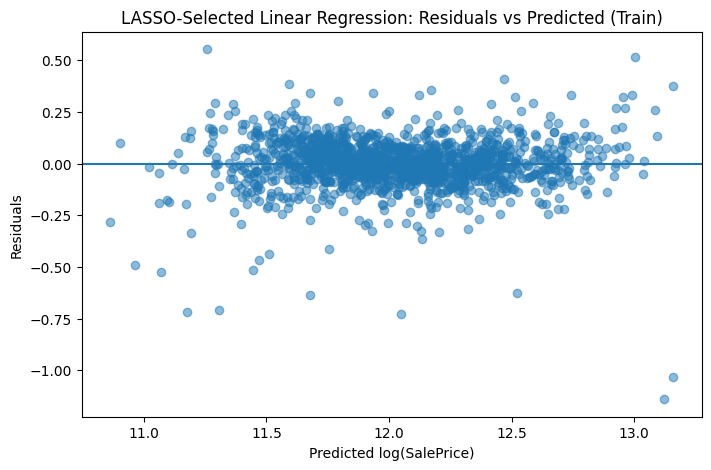

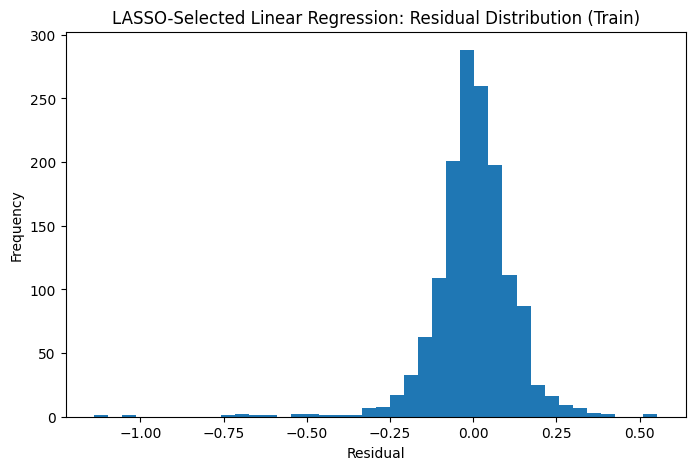

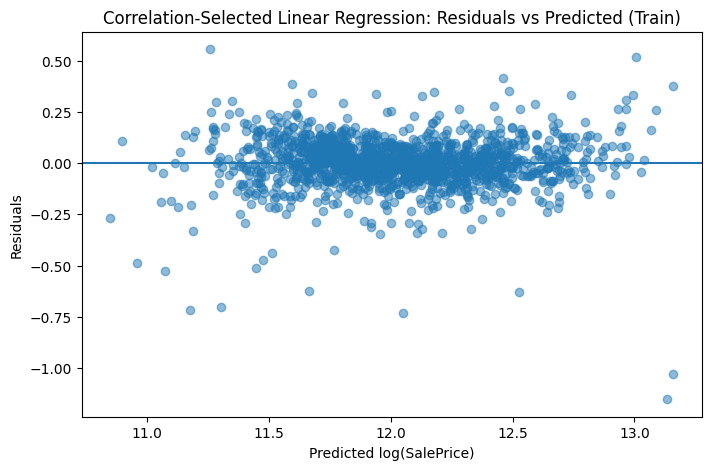

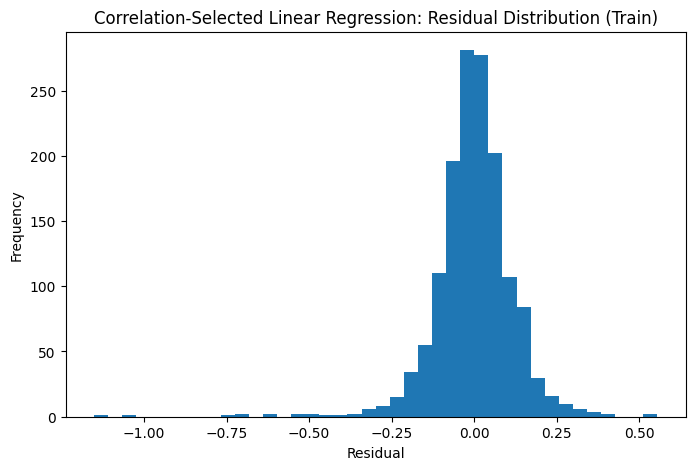

In [162]:
y = y_train_log

def residual_plots(X, y, title_prefix="Model"):
    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    residuals = y - y_pred

    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0)
    plt.title(f"{title_prefix}: Residuals vs Predicted (Train)")
    plt.xlabel("Predicted log(SalePrice)")
    plt.ylabel("Residuals")
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=40)
    plt.title(f"{title_prefix}: Residual Distribution (Train)")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()


residual_plots(X_train_selected, y, title_prefix="LASSO-Selected Linear Regression")

residual_plots(X_corr_selected, y, title_prefix="Correlation-Selected Linear Regression")


We have tried advanced models like Ridge ,LASSO, Polynomial Regression using correleation selected features as training data.


In [163]:
X = X_corr_selected
y = y_train_log

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def eval_model(model, X, y, name="Model"):
    rmse = -cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error").mean()
    r2 = cross_val_score(model, X, y, cv=kf, scoring="r2").mean()
    return {"Model": name, "CV_RMSE_log": rmse, "CV_R2": r2}

results = []

ridge_alphas = [0.1, 1, 10, 50, 100]
for a in ridge_alphas:
    model = Ridge(alpha=a)
    results.append(eval_model(model, X, y, name=f"Ridge(alpha={a})"))

lasso_alphas = [0.0005, 0.001, 0.003, 0.01]
for a in lasso_alphas:
    model = Lasso(alpha=a, max_iter=8000, random_state=42)
    results.append(eval_model(model, X, y, name=f"Lasso(alpha={a})"))

poly_ridge_alphas = [1, 10, 50]
for a in poly_ridge_alphas:
    poly_model = Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("ridge", Ridge(alpha=a))
    ])
    results.append(eval_model(poly_model, X, y, name=f"Poly(deg=2)+Ridge(alpha={a})"))

results_df = pd.DataFrame(results).sort_values("CV_RMSE_log")
results_df


,Model,CV_RMSE_log,CV_R2
2,Ridge(alpha=10),0.127684,0.894304
5,Lasso(alpha=0.0005),0.127768,0.894082
1,Ridge(alpha=1),0.127776,0.893987
0,Ridge(alpha=0.1),0.127818,0.893895
6,Lasso(alpha=0.001),0.128113,0.893636
3,Ridge(alpha=50),0.128949,0.892552
4,Ridge(alpha=100),0.130562,0.890097
7,Lasso(alpha=0.003),0.131836,0.887796
8,Lasso(alpha=0.01),0.137529,0.878334
11,Poly(deg=2)+Ridge(alpha=50),0.145531,0.862365


Ridge and Lasso regression models achieve the lowest cross-validated RMSE, showing that simple regularized linear models perform best on the correlation-selected features. In contrast, polynomial regression increases error despite regularization, indicating that adding non-linear interactions does not improve performance for this dataset.

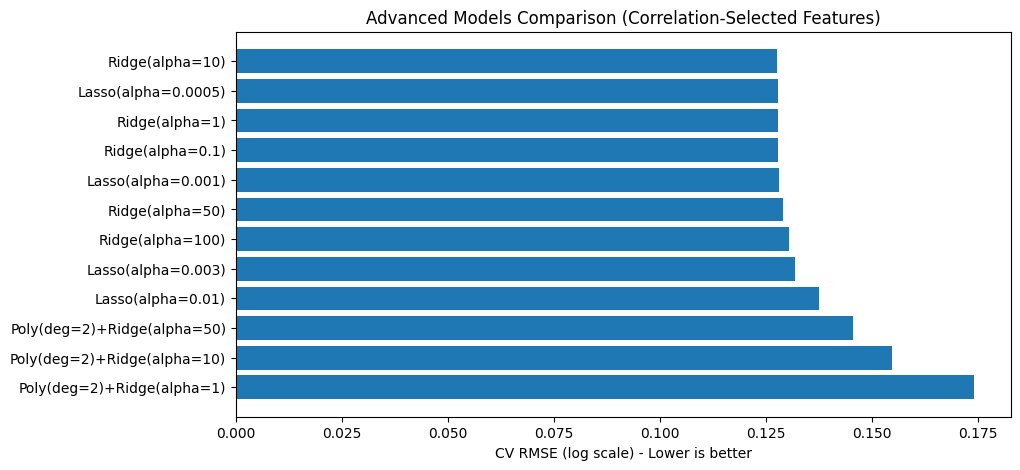

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(results_df["Model"], results_df["CV_RMSE_log"])
plt.title("Advanced Models Comparison (Correlation-Selected Features)")
plt.xlabel("CV RMSE (log scale) - Lower is better")
plt.gca().invert_yaxis()
plt.show()
